## Research Paper Segmentation 

*CS445 Computational Photography Final Project*

- Bruno Seo (sbseo2)
- Michal Gryga (mgryga2)

References
- https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

### Load Packages

In [1]:
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
import os
from collections import defaultdict
from matplotlib import pyplot as plt
import copy

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Download Proposed Model

In [2]:
!wget https://uofi.box.com/shared/static/yb7i1ngyfzg7y352zsj0hp729k19w2i0.pth -O model.pth

### Set Data Directory

In [3]:
tst_dir = './tst/'

### Load Model

- Please change `num_classes` if you training multiple classes

In [4]:
num_classes = 4 # 3classes(title+author+abstract) + background

In [5]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
model.load_state_dict(torch.load('./model.pth', map_location=device))
model.to(device)
model.eval() # Change model to testing mode

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

### Create Testing Dataset

In [7]:
class TestDataset(object):
    def __init__(self, tst_dir):
        self.img_dic = defaultdict()
        
        im_list = os.listdir(tst_dir)
        self.num_images = len(im_list)
        for i in range(1,self.num_images+1):
            im = cv2.imread(tst_dir+'{}.jpg'.format(i))/255.0
            im = im.astype('float32')
            self.img_dic[i-1] = cv2.resize(im, (int(im.shape[1]), int(im.shape[0])))
        
    def __getitem__(self, idx):

        im = self.img_dic[idx]
        img = torchvision.transforms.ToTensor()(im)
        
        return img, _

    def __len__(self):
        return self.num_images

In [8]:
test_dataset = TestDataset(tst_dir)
def collate_fn(batch):
    return tuple(zip(*batch))
test_data_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

### Evaluation

Evaluate some dataset

In [9]:
label_dict = {1:'title', 2:'author', 3:'abstract'}
color_dict = {1:(220,0,0), 2:(0,220,0), 3:(0,0,220)}

In [10]:
result = list()
for i, (images, _) in enumerate(test_data_loader):
    images = list(image.to(device) for image in images)
    outputs = model(images)

    idx = 0 # I do not know why this value should be 0
    sample = images[idx].permute(1,2,0).cpu().numpy().copy()
    boxes = outputs[idx]['boxes'].data.cpu().numpy()
    scores = outputs[idx]['scores'].data.cpu().numpy()
    labels = outputs[idx]['labels'].data.cpu().numpy()
    
    path = list()
    for lbl, _, box in sorted(list(zip(labels, scores, boxes)), key=lambda x: x[1], reverse=True):
    
        if lbl not in path:
            x_min, y_min = box[0], box[1]
            x_max, y_max = box[2], box[3]
                    
            cv2.rectangle(sample, (x_min, y_min), (x_max, y_max), color_dict[lbl],2)   
            cv2.putText(sample, label_dict[lbl], (int(x_min-10), int(y_min-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA) 
            path.append(lbl)

    result.append(sample)

/Users/sbseo/.pyenv/versions/3.5.9/lib/python3.5/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
../torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


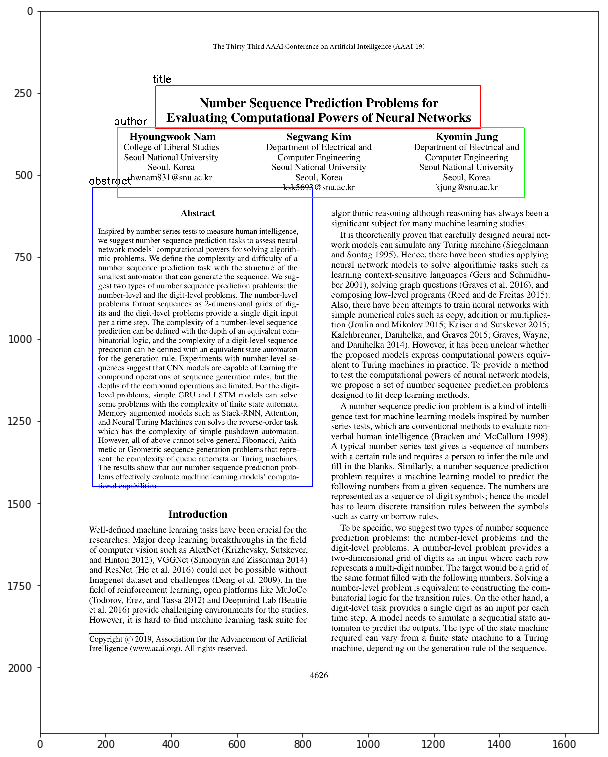

In [11]:
plt.figure(figsize=(10,15))
plt.imshow(result[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


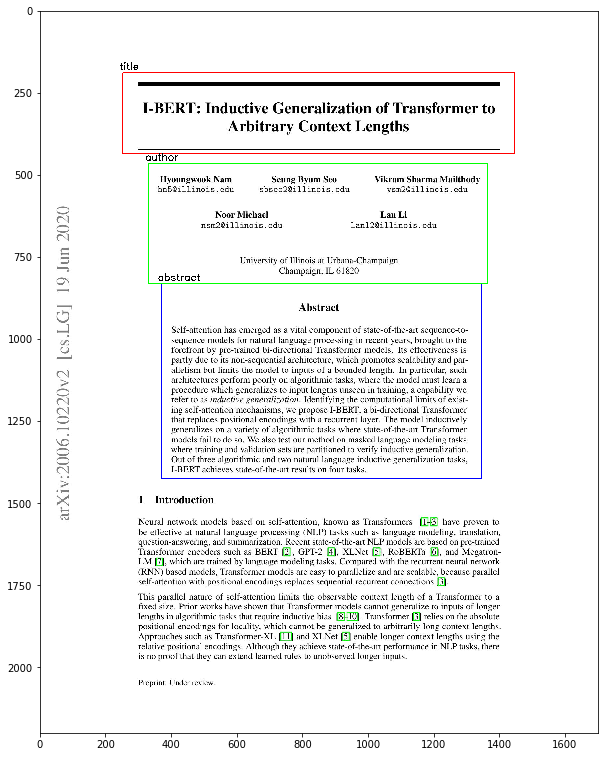

In [12]:
plt.figure(figsize=(10,15))
plt.imshow(result[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


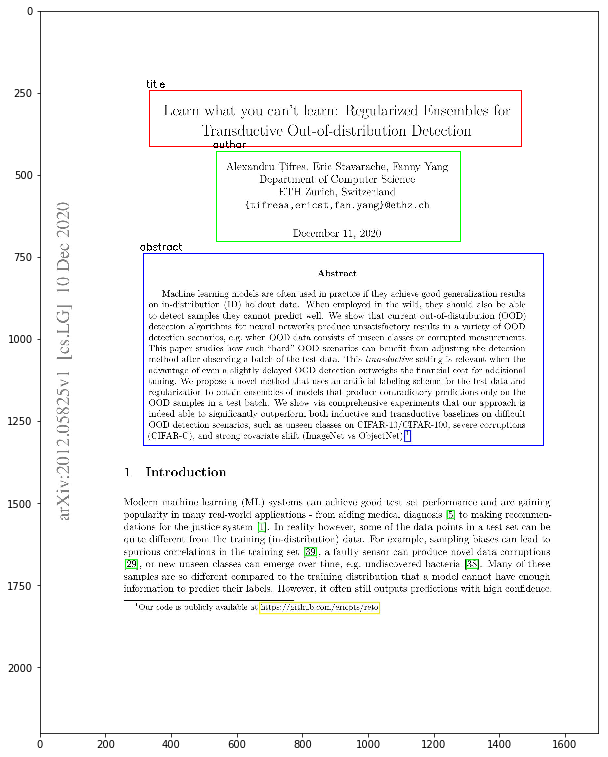

In [13]:
plt.figure(figsize=(10,15))
plt.imshow(result[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


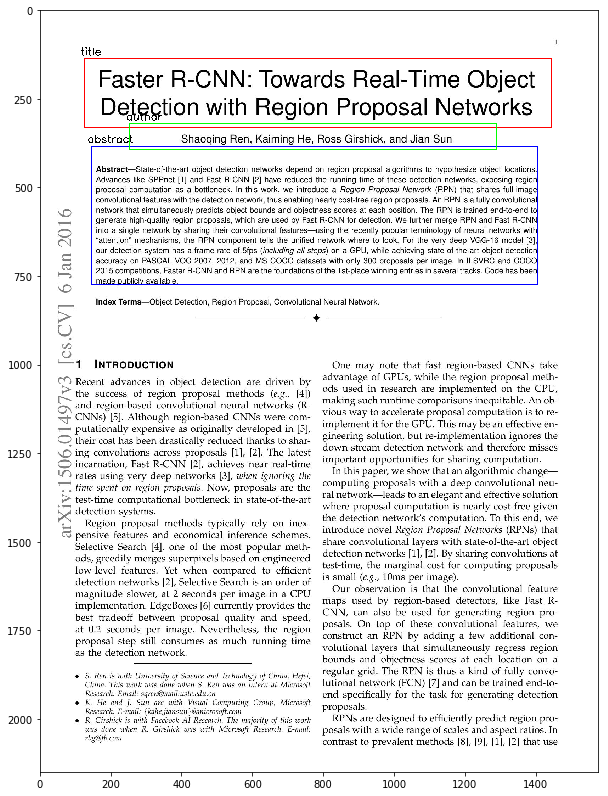

In [14]:
plt.figure(figsize=(10,15))
plt.imshow(result[3])

### Uncomment here to save results

In [18]:
# for i, im in enumerate(result,1):
#     im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#     cv2.imwrite("./output/{}.jpg".format(i), im*255.0)